In [8]:
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import pandas as pd
import geopandas as gpd


In [9]:
UNKNOWN_ZONES   = {264, 265}
PU_COLS         = ["PULocationID", "PUlocationID"]
DO_COLS         = ["DOLocationID", "DOlocationID"]
ZONE_COLS       = PU_COLS + DO_COLS
# ------------------------------------------------------

def load_and_process_data(parquet_file: str) -> pd.DataFrame:
    """
    Đọc 1 parquet row‑group, convert thời gian, 
    bỏ dòng thiếu dữ liệu chính và *loại* mọi record có zone 264/265.
    """
    # 1) load 1 row group (nhẹ RAM)
    reader = pq.ParquetFile(parquet_file)
    table  = reader.read_row_group(0)
    df     = table.to_pandas()

    # 3) convert datetime
    datetime_cols = ['request_datetime', 'pickup_datetime',
                     'dropoff_datetime', 'on_scene_datetime']
    for col in datetime_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # 4) drop dòng thiếu dữ liệu quan trọng
    df = df.dropna(subset=['pickup_datetime',
                           'request_datetime',
                           'dropoff_datetime',
                           'base_passenger_fare'])

    # 5) loại bỏ trip có zone nằm trong UNKNOWN_ZONES
    #    (tự dò xem cột PU/DO có tồn tại)
    zone_cols_present = [c for c in ZONE_COLS if c in df.columns]
    if zone_cols_present:
        df = df[~df[zone_cols_present].isin(UNKNOWN_ZONES).any(axis=1)]

    return df

# ---- gọi thử ----
df = load_and_process_data("../data/fhvhv_tripdata_2025-01.parquet")
print(len(df), f"rows retained after filtering {UNKNOWN_ZONES} .")


1002470 rows retained after filtering {264, 265} .


In [10]:
df.head(5)

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag,cbd_congestion_fee
0,HV0003,B03404,B03404,2025-01-01 00:28:07,2025-01-01 00:31:17,2025-01-01 00:33:25,2025-01-01 00:54:24,148,211,1.320,...,2.75,0.0,0.0,15.71,N,N,N,N,N,0.0
1,HV0005,B03406,None,2025-01-01 00:18:33,NaT,2025-01-01 00:29:49,2025-01-01 00:41:52,127,244,3.313,...,0.00,0.0,0.0,23.57,N,N,N,N,N,0.0
2,HV0003,B03404,B03404,2025-01-01 00:28:22,2025-01-01 00:31:52,2025-01-01 00:32:39,2025-01-01 01:20:33,132,181,13.430,...,0.00,2.5,0.0,47.75,N,N,N,N,N,0.0
3,HV0003,B03404,B03404,2025-01-01 00:27:13,2025-01-01 00:33:58,2025-01-01 00:34:55,2025-01-01 00:39:19,76,76,0.820,...,0.00,0.0,0.0,12.20,N,N,N,N,N,0.0
4,HV0003,B03404,B03404,2025-01-01 00:33:29,2025-01-01 00:45:46,2025-01-01 00:46:19,2025-01-01 00:53:56,76,76,1.610,...,0.00,0.0,0.0,17.67,N,N,N,N,N,0.0


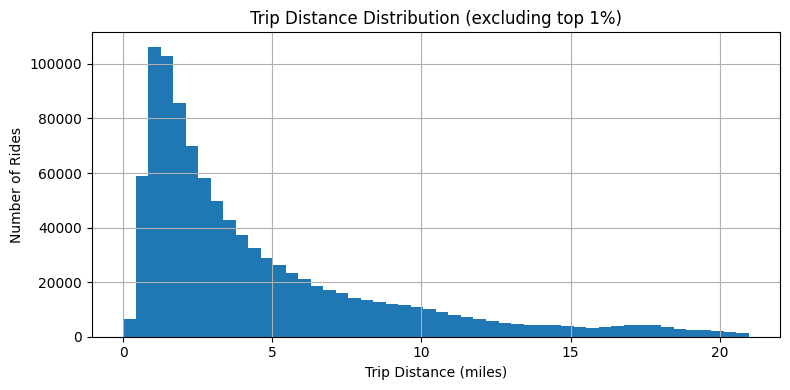

In [11]:
plt.figure(figsize=(8, 4))
plt.hist(df['trip_miles'], bins=50, range=(0, df['trip_miles'].quantile(0.99)))
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Number of Rides')
plt.title('Trip Distance Distribution (excluding top 1%)')
plt.grid(True)
plt.tight_layout()
plt.show()


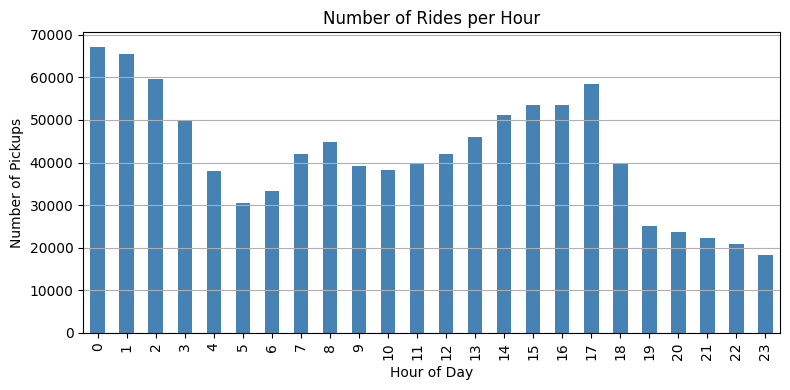

In [12]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['hour'] = df['pickup_datetime'].dt.hour

plt.figure(figsize=(8, 4))
df['hour'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.title('Number of Rides per Hour')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


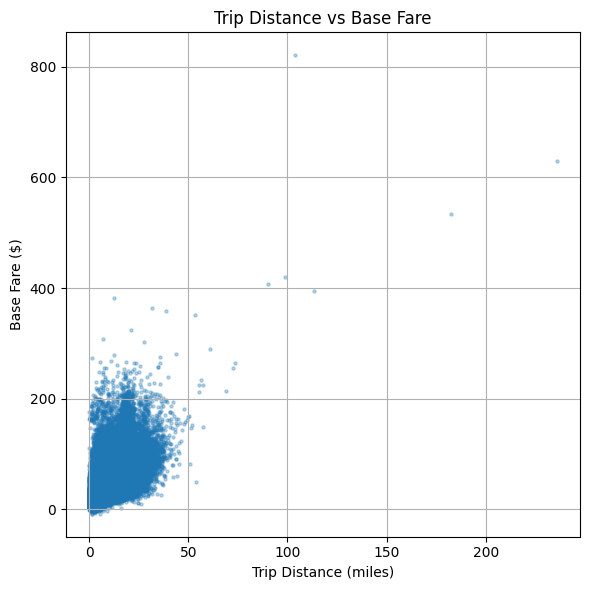

In [13]:
plt.figure(figsize=(6, 6))
plt.scatter(df['trip_miles'], df['base_passenger_fare'], alpha=0.3, s=5)
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Base Fare ($)')
plt.title('Trip Distance vs Base Fare')
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# Đường dẫn đến shapefile đã giải nén
shapefile_path = "../data/taxi_zones/taxi_zones.shp"

# Đọc shapefile
zones = gpd.read_file(shapefile_path)

# Đọc lookup table
lookup = pd.read_csv("../data/taxi_zone_lookup.csv")

# Giả sử df là DataFrame chứa dữ liệu chuyến đi với cột 'PULocationID'
# Đếm số lần đón khách tại mỗi LocationID
pickup_counts = df['PULocationID'].value_counts().reset_index()
pickup_counts.columns = ['LocationID', 'pickup_count']

# Gộp dữ liệu với shapefile
zones['LocationID'] = zones['LocationID'].astype(int)
zones = zones.merge(pickup_counts, on='LocationID', how='left')
zones['pickup_count'] = zones['pickup_count'].fillna(0)


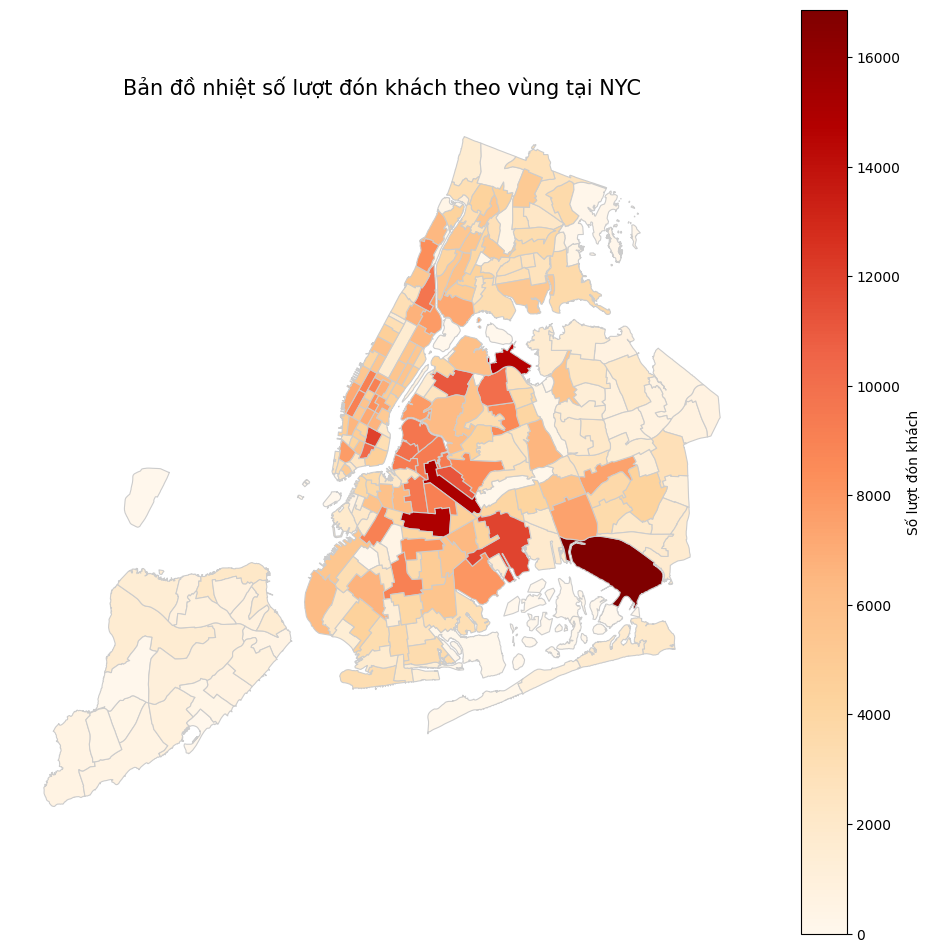

In [15]:
# Thiết lập kích thước hình ảnh
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Vẽ bản đồ nhiệt
zones.plot(column='pickup_count',
           cmap='OrRd',
           linewidth=0.8,
           ax=ax,
           edgecolor='0.8',
           legend=True,
           legend_kwds={'label': "Số lượt đón khách"})

# Thêm tiêu đề
plt.title('Bản đồ nhiệt số lượt đón khách theo vùng tại NYC', fontsize=15)

# Ẩn trục
plt.axis('off')

# Hiển thị bản đồ
plt.show()
